# Telco Churn Data Set


Data was obtained from [Kaggle](https://www.kaggle.com/blastchar/telco-customer-churn) and is an IBM Sample Data Set.


# Table of Contents
<a id='tc'> </a>

+ [Importing Libraries](#importl)
+ [Functions](#functions)
    - [Visualization Tools](#visfun)
    - [Evaluation Metrics](#evalfun)
+ [Importing Data](#import)
+ [Data Exploration and Preperation](#explore)
    - [Data Overview](#do)
    - [Data Cleaning](#dc)
    - [Convert Categorical to Numerical](#num)
    - [Data Visualization](#dv)
    - [Extract Training Set](#ts)
    - [Pearsons Correlation](#pc)
+ [Feature Selection and Modeling](#fs)
    - [Train and Test Split plus SMOTE](#tts)
    - [Select K Best](#skb)
    - [PCA](#pca)
    - [Logistic Regression](#lr)
    - [Decision Trees](#dt)
    - [Random Forest](#rf)
    - [K Nearest Neighbors](#knn)
+ [Summary](#summary)


Here are what the various columns represent:

<ol>

<li> customerID:      Customer ID
<li> gender:          Whether the customer is a male or a female
<li> SeniorCitizen:   Whether the customer is a senior citizen or not (1, 0)
<li> Partner:         Whether the customer has a partner or not (Yes, No)
<li> Dependents:      Whether the customer has dependents or not (Yes, No)
<li> tenure:          Number of months the customer has stayed with the company
<li> PhoneService:    Whether the customer has a phone service or not (Yes, No)
<li> MultipleLines:   Whether the customer has multiple lines or not (Yes, No, No phone service)
<li> InternetService: Customer’s internet service provider (DSL, Fiber optic, No)
<li> OnlineSecurity:  Whether the customer has online security or not (Yes, No, No internet service)
<li> OnlineBackup:    Whether the customer has online backup or not (Yes, No, No internet service)
<li> DeviceProtection:Whether the customer has device protection or not (Yes, No, No internet service)
<li> TechSupport:     Whether the customer has tech support or not (Yes, No, No internet service)
<li> StreamingTV:     Whether the customer has streaming TV or not (Yes, No, No internet service)
<li> StreamingMovies: Whether the customer has streaming movies or not (Yes, No, No internet service)
<li> Contract:        The contract term of the customer (Month-to-month, One year, Two year)
<li> PaperlessBilling:Whether the customer has paperless billing or not (Yes, No)
<li> PaymentMethod:   The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)) 
<li> MonthlyCharges:  The amount charged to the customer monthly
<li> TotalCharges:    The total amount charged to the customer
<li> Churn:           Whether the customer churned or not (Yes or No)

</ol>

<a id='importl'> </a>
<h2>Importing Libraries</h2>

In [54]:

import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
from sklearn.preprocessing import LabelEncoder
import pylab as pl
%matplotlib inline 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
#init_notebook_mode()
import plotly.io as pio
#from IPython.display import Image
init_notebook_mode(connected=True)

from yellowbrick.classifier import DiscriminationThreshold
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
import itertools
from sklearn.preprocessing import LabelEncoder, StandardScaler, scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, jaccard_score, classification_report, log_loss, zero_one_loss, accuracy_score, plot_roc_curve, roc_auc_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree

import warnings
warnings.filterwarnings('ignore')


<h2>Functions</h2>

<a id='functions'></a>

<a id='visfun'></a>
### Visualization Tools

[Go to TOC](#tc)

In [59]:
# Global Variables used for converting Column names into Clean text 
column_name_to_text = {
    'gender': 'Gender',
    'SeniorCitizen': 'senior citizen',
    'Partner': 'Customers with a Partner',
    'Dependents': 'Customers with Dependents',
    'tenure': 'Total Tenure',
    'PhoneService': 'Customer with a Phone Service',
    'MultipleLines': 'Customer with Multiple Lines',
    'InternetService': 'Customer’s Internet Service Provider',
    'OnlineSecurity': 'Customer’s with Online Security',
    'OnlineBackup': 'Customer’s with Online Backup',
    'DeviceProtection': 'Customer’s with Device Protection',
    'TechSupport': 'Customer’s That Have Used Tech Support',
    'StreamingTV': 'Customer’s Streaming TV',
    'StreamingMovies': 'Customer’s Streaming Movies',
    'Contract': 'Customer’s Contract Length',
    'PaperlessBilling': 'Customer with Paperless Billing',
    'PaymentMethod': 'Customer’s Payment Method',
    'MonthlyCharges': 'Customer’s Monthly Charges',
    'TotalCharges': 'Customer’s Total Charges'
    
}

In [56]:
def pie_chart_compare_churn(column_name):
    # Create subplots: use 'domain' type for Pie subplot
    fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
    fig.add_trace(go.Pie( labels=churn_df[churn_df.Churn == 'Yes'][[column_name,'Churn']].groupby(column_name).count().index.values, 
                      values=churn_df[churn_df.Churn == 'Yes'][[column_name,'Churn']].groupby(column_name).count().to_numpy().ravel(), 
                     name="Churn = Yes"),
              1, 1)
    fig.add_trace(go.Pie( labels=churn_df[churn_df.Churn == 'No'][[column_name,'Churn']].groupby(column_name).count().index.values, 
                      values=churn_df[churn_df.Churn == 'No'][[column_name,'Churn']].groupby(column_name).count().to_numpy().ravel(), 
                     name="Churn = No"),
              1, 2)

    # Use `hole` to create a donut-like pie chart
    fig.update_traces(hole=.4, hoverinfo="label+percent+name")
          
    fig.update_layout(
    title_text="Distribution of "+column_name_to_text[column_name]+ " Who Churn (Yes) and Do Not (No)",
    # Add annotations in the center of the donut pies to indicate churn
    annotations=[dict(text='Yes', x=0.18, y=0.5, font_size=20, showarrow=False),
                 dict(text='No', x=0.82, y=0.5, font_size=20, showarrow=False)])
    iplot(fig)
#    pio.write_image(fig, 'images/pie_'+column_name+'.png')
    
    

In [4]:
def histogram_compare_churn(column_name):
    fig = go.Figure() 
    
    fig.add_trace(go.Histogram(x=churn_df[churn_df.Churn=='Yes'][[column_name]].to_numpy().ravel(),
                           histnorm='probability',
                           name='Churn = Yes'
                              ))
    fig.add_trace(go.Histogram(x=churn_df[churn_df.Churn=='No'][[column_name]].to_numpy().ravel(),
                           histnorm='probability',
                           name='Churn = No'
                              ))
    
    fig.update_traces(opacity=0.9)

    fig.update_layout(
        title_text='Histogram of '+column_name_to_text[column_name], # title of plot
        xaxis_title_text=column_name_to_text[column_name], # xaxis label
        yaxis_title_text='Probability', # yaxis label
        bargap=0.2, # gap between bars of adjacent location coordinates
        bargroupgap=0.1 # gap between bars of the same location coordinates
    )
    iplot(fig)
#    pio.write_image(fig, 'images/histogram_'+column_name+'.png')

Below creates table of percent difference in yes or no Churn groups for categorical variables 

In [5]:
def get_churn_table():
    features = churn_num_df.drop(['customerID', 'tenure','MonthlyCharges','TotalCharges'],axis=1).T.index.to_numpy()
    feature_option_array = np.array([])
    percent_array = np.array([])

    for i,feature in enumerate(features):
        if feature != 'Churn':
            feature_options = churn_df[churn_df.Churn == 'Yes'][[feature,'Churn']].groupby(feature).count().index.to_numpy()
            query_y = churn_df[churn_df.Churn == 'Yes'][[feature,'Churn']].groupby(feature).count().to_numpy().ravel()
            query_n = churn_df[churn_df.Churn == 'No'][[feature,'Churn']].groupby(feature).count().to_numpy().ravel()
            query_y = query_y/np.sum(query_y)
            query_n = query_n/np.sum(query_n)
            diff = query_y - query_n
            index = np.argmax( np.absolute(diff) )
            percent_array = np.append(percent_array, np.round(100*diff[index],2))
            feature_option_array = np.append( feature_option_array, feature_options[index])

    fig = go.Figure(data=[go.Table(
              header=dict(
                values=[ ['Feature'],
                          ['Categorical Option with Max % Difference'],
                          ['Percent Difference (Yes - No)']],
                line_color='black', fill_color='red',
                align='center',font=dict(color='black', size=12)
                          ),
              cells=dict(
                    values=[features, feature_option_array, percent_array],
                    line_color = 'black',
                    fill_color = 'blue',
                    align='center', font=dict(color='white', size=11)
                        ))
                        ])

    iplot(fig)
 #   pio.write_image(fig, 'images/churn_table.png')
    

### Training / Parameter Selection

#### PCA

Principle Component Analysis finds a orthonormal set of basis vectors that describes feature space where the new basis vectors are linearly uncorrelated. 

The function runs PCA, ranks basis vectors by amount of variance contained, and plots how much variance is captured when adding in each new basis vector. 

In [80]:
def pca(X_train, y_train):
    pca = PCA()
    # Plot the PCA spectrum
    pca.fit(X_train)
    
    fig = make_subplots(rows=3, cols=1
                       )
    trace1 = go.Scatter( x= np.arange(1, pca.n_components_ + 1),
                       y= pca.explained_variance_ratio_,
                       )
    
    trace2 = go.Heatmap(
                   z=pca.components_[0:3,:],
                   x=features,
                   y=['1st Comp','2nd Comp','3rd Comp'],
                   hoverongaps = False
                            )
    
    fig.append_trace(trace1,row = 1, col =1)
    fig.append_trace(trace2,row = 3, col=1)

    fig.update_xaxes(title_text='n_components',type="log", row=1, col=1)
    fig.update_yaxes(title_text='PCA explained variance ratio', row=1, col=1)
    
    iplot(fig)
#    pio.write_image(fig, 'images/pca.png')
    

#### Select k Best 

The function below will compare performance using percent accuracy versus the number of features selected by using  SelectKBest.  It will also create a bar graph of the score of each feature.

The SelectKBest function uses chi-squared test to evaluate the features.

In [78]:

def select_k_best(X,y):
# how does performance of data change with number of input features ranked using SelectKBest
    pa_array = np.array([])
    jss_array = np.array([])
    karray = np.linspace(1,18,18)
    pa_array = np.zeros(len(karray))
    for i,k in enumerate(karray):
        selector = SelectKBest(chi2, k=int(k))
        X_new = selector.fit_transform(X, y)
        X_new2 = StandardScaler().fit(X_new).transform(X_new)
        X_train, X_test, y_train, y_test = train_test_split( X_new2, y, test_size=0.2, random_state=4)
        cols = selector.get_support(indices=True) 
        col_names = churn_num_df.iloc[:,cols].T.index.to_numpy()
        LR = LogisticRegression(C=10, solver='liblinear').fit(X_train,y_train)
        yhat = LR.predict(X_test)
        pa_array[i] = percent_accurate(y_test,yhat)
        pa_array[i] = roc_auc_score(y_test, LR.predict_proba(X_test)[:,1] )  #LR.predict_proba(X_test) )
    W = selector.fit(X,y)
    score, feature_sorted = zip(*sorted(zip(W.scores_, features)))
    score, feature_sorted = (list(t) for t in zip(*sorted(zip(score, feature_sorted))))
    
    fig = make_subplots(rows=3, cols=1) 
    
    trace1 = go.Scatter( x= karray,
                         y= pa_array,
                         name = 'Performance'
                       )
    trace2 = go.Bar(x=feature_sorted, y=score, name='Feature Importance')
    
    fig.append_trace(trace1,row = 1, col =1, )
    fig.append_trace(trace2,row = 3, col=1)
    
    fig.update_xaxes(title_text='k = number of features', row=1, col=1) #type="log"
    fig.update_yaxes(title_text='AUROC', row=1, col=1)
    
    fig.update_yaxes(type='log', row=3, col=1)
    fig.update_yaxes(title_text='feature score', row=3, col=1)
    
    iplot(fig)
#    pio.write_image(fig, 'images/selectkbest.png')
    

#### Logistic Regression Cross Validation

Cross validation function I created for LR.  I did this instead of using sklearn because I would like to train my model using SMOTE but only test the model on actual data. 

In [8]:
# just removed portion of this function which plot score versus Carray 
def logistic_cross_val(Carray,X_train,y_train,X_test,y_test, score_type='percent accuracy',samp='SMOTE'):
    clfarray = []
    scorearray = np.array([])
    for i,C in enumerate(Carray):
        clfarray.append( LogisticRegression( solver='liblinear', tol=1e-6, max_iter=int(1e6), C=C) )
        clfarray[i].fit(X_train,y_train)
        if score_type == 'auroc':
            auroc = roc_auc_score(y_test, clfarray[i].predict_proba(X_test)[:,1] )   
            scorearray = np.append(scorearray,auroc)
        elif score_type == 'percent accuracy':
            scorearray = np.append(scorearray,percent_accurate(y_test,clfarray[i].predict(X_test)))
    print('scorearray', scorearray)
    print('best ', score_type,' score', scorearray[np.argmax(scorearray)])
    fig = px.scatter(x=Carray, y=scorearray) #mode='lines+markers')
    fig = px.line(x=Carray, y=scorearray) #mode='lines+markers')
    fig.update_xaxes(title_text='C',type="log")
    fig.update_yaxes(title_text=score_type)
    iplot(fig)
#    pio.write_image(fig, 'images/Logistic_regression_'+samp+'.png')
    return clfarray[np.argmax(scorearray)]

<a id='evalfun'> </a>
### Evaluation Metrics

#### confusion matrix

In [9]:
def plot_confusion_matrix(cm, # confusion matrix
                          classes, # test to describe what the output of the classes may be (1 or 0 in case of Churn)
                          normalize=False, #
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Compute multiple metrics in one function for class 

Metrics below:
<ol>
     <li> Jacard Index: size of the intersection divided by the size of the union of two label sets </li>
     <li> Classification Report:
         <ol>
             <li> Precision: Accuracy of positive predictions; Precision = TP/(TP + FP)
             <li> Recall: Fraction of positives that were correctly identified; Recall = TP/(TP+FN)
             <li> F1 score: weighted  mean of precision and recall; best score is 1.0 and the worst is 0.0; F1 Score = 2*(Recall * Precision) / (Recall + Precision)
             <li> Support: number of samples of the true response that lie in that class. 
         </ol>
     <li> confusion matrix gives number or percent of TP, TN, FP, FN 
</ol>

In [10]:
def compute_all_evaluation_metrics(rfc, X_test, y_test, plot_cm = True, print_summary = True):
    # compute jacard index
    y_hat = rfc.predict(X_test)
    jss = jaccard_score(y_test, y_hat)
    # compute confustion matrix and plot 
    cnf_matrix = confusion_matrix(y_test, y_hat, labels=[1,0])
    np.set_printoptions(precision=2)
    # plot confusion matrix
    if plot_cm:
        plt.figure()
        plot_confusion_matrix(cnf_matrix, classes=['churn=1','churn=0'],normalize= True,  title='Confusion matrix')
    # classification_report
    c_report = classification_report(y_test, y_hat)
    percent_accuracy = percent_accurate(y_test,y_hat)
    vis = plot_roc_curve(rfc, X_test, y_test)
    auroc = vis.roc_auc
    if print_summary:
        print('Jaccard Similarity Score:', jss)
        print('confusion matrix:', cnf_matrix)
        print('classification report:')
        print( c_report)
        print('percent accuracy:',percent_accurate(y_test,y_hat))
    return jss, cnf_matrix, c_report, percent_accuracy, auroc 

#### Percent Accuracy -- returns percentage of points accuractely classified

In [11]:
def percent_accurate(y_test,y_hat):
    cnf_matrix = confusion_matrix(y_test, y_hat, labels=[1,0])
    return np.sum(np.diagonal(cnf_matrix))/np.sum(cnf_matrix)

<h2>Importing Data</h2>

<a id='import'></a>

[Go to TOC](#tc)

In [12]:
churn_df = pd.read_csv("Telco_customer_churn.csv")
churn_df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

## Data exploration

<a id='explore'> </a>

[Go to TOC](#tc)

### Data overview

<a id='do'> </a>
Check size of data

In [13]:
np.shape(churn_df)

(7043, 21)

Check types of data objects

In [14]:
churn_df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Checking for null values in data

In [15]:
churn_df.isnull().values.any()

False

### Data Cleaning
<a id='dc'></a>
TotalCharges should be float.  Doing group by to determine if issue with data. 

In [16]:
churn_df.groupby('TotalCharges').mean() 

SeniorCitizen  tenure  MonthlyCharges
TotalCharges                                       
                        0.0     0.0       41.418182
100.2                   0.0     5.0       24.300000
100.25                  0.0     1.0      100.250000
100.35                  0.0     6.0       20.100000
100.4                   0.0     5.0       24.950000
...                     ...     ...             ...
997.75                  0.0    51.0       19.400000
998.1                   0.0    55.0       19.150000
999.45                  0.0    13.0       75.000000
999.8                   0.0    12.0       85.050000
999.9                   0.0    11.0       94.200000

[6531 rows x 3 columns]

Above we can see that there is an empty string as some of the inputs.  Droping these data points below

In [17]:
churn_df = churn_df.drop(churn_df[churn_df['TotalCharges'] == ' '].index)
churn_df['TotalCharges']= pd.to_numeric(churn_df['TotalCharges'])
churn_df.head(5)

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges  Churn  
0           Electronic check          29.85         29.85     No  
1               Mailed check          56.95       1889.50     No  
2               Mailed check          53.85        108.15    Yes  
3  Bank transfer (automatic)          42.30       1840.75     No  
4           Electronic check          70.70        151.65    Yes  

[5 rows x 21 columns]

### Covert categorical data into numerical 

<a id='num'></a>

First I will make copy of dataframe which will store the numerical version of dataset

In [18]:
churn_num_df = churn_df.copy() 

First let's consider the cases where the options are No, Yes or one other values.  All cases are bolded below.  I have also struck through any cases where there is already a numerical feature.

<ol>

<li> <strike>customerID:      Customer ID</strike> # Note will not use this feature
<li> gender:          Whether the customer is a male or a female
    <li> <strike>SeniorCitizen:   Whether the customer is a senior citizen or not (1, 0)</strike>
<li> <b>Partner:         Whether the customer has a partner or not (Yes, No)</b>
<li> <b>Dependents:      Whether the customer has dependents or not (Yes, No)</b>
    <li> <strike>tenure:          Number of months the customer has stayed with the company</strike>
<li> <b>PhoneService:    Whether the customer has a phone service or not (Yes, No)</b>
<li> <b>MultipleLines:   Whether the customer has multiple lines or not (Yes, No, No phone service)</b>
    <li> InternetService: Customer’s internet service provider (DSL, Fiber optic, No)
<li> <b>OnlineSecurity:  Whether the customer has online security or not (Yes, No, No internet service)</b>
<li> <b>OnlineBackup:    Whether the customer has online backup or not (Yes, No, No internet service)</b>
<li> <b>DeviceProtection:Whether the customer has device protection or not (Yes, No, No internet service)</b>
<li> <b>TechSupport:     Whether the customer has tech support or not (Yes, No, No internet service)</b>
<li> <b>StreamingTV:     Whether the customer has streaming TV or not (Yes, No, No internet service)</b>
<li> <b>StreamingMovies: Whether the customer has streaming movies or not (Yes, No, No internet service)</b>
<li> Contract:        The contract term of the customer (Month-to-month, One year, Two year)
    <li> <b>PaperlessBilling:Whether the customer has paperless billing or not (Yes, No)</b>
<li> PaymentMethod:   The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)) 
    <li> <strike>MonthlyCharges:  The amount charged to the customer monthly </strike>
<li> <strike>TotalCharges:    The total amount charged to the customer </strike>
<li> <strike>Churn:           Whether the customer churned or not (Yes or No)</strike>

</ol>

This leaves us with the following values that could be replaced: No, Yes, No phone service, No internet service

In [19]:
label_dictionary = {'No': 0.0, 'Yes': 1.0, 'No phone service': 2.0, 'No internet service':2.0}
churn_num_df = churn_num_df.replace(['No','Yes','No phone service','No internet service'],[0.0,1.0,2.0,2.0])
churn_num_df.head(5)

customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
0  7590-VHVEG  Female              0      1.0         0.0       1   
1  5575-GNVDE    Male              0      0.0         0.0      34   
2  3668-QPYBK    Male              0      0.0         0.0       2   
3  7795-CFOCW    Male              0      0.0         0.0      45   
4  9237-HQITU  Female              0      0.0         0.0       2   

   PhoneService  MultipleLines InternetService  OnlineSecurity  ...  \
0           0.0            2.0             DSL             0.0  ...   
1           1.0            0.0             DSL             1.0  ...   
2           1.0            0.0             DSL             1.0  ...   
3           0.0            2.0             DSL             1.0  ...   
4           1.0            0.0     Fiber optic             0.0  ...   

   DeviceProtection  TechSupport  StreamingTV  StreamingMovies  \
0               0.0          0.0          0.0              0.0   
1               1.0          0.0          0.0              0.0   
2               0.0          0.0          0.0              0.0   
3               1.0          1.0          0.0              0.0   
4               0.0          0.0          0.0              0.0   

         Contract PaperlessBilling              PaymentMethod MonthlyCharges  \
0  Month-to-month              1.0           Electronic check          29.85   
1        One year              0.0               Mailed check          56.95   
2  Month-to-month              1.0               Mailed check          53.85   
3        One year              0.0  Bank transfer (automatic)          42.30   
4  Month-to-month              1.0           Electronic check          70.70   

   TotalCharges  Churn  
0         29.85    0.0  
1       1889.50    0.0  
2        108.15    1.0  
3       1840.75    0.0  
4        151.65    1.0  

[5 rows x 21 columns]

The tranformations above have fixed the majority of our features. Note: we will not use CustomerID as feature.  Now, we have the following features to fix.

<ol>
<li> gender:          Whether the customer is a male or a female
<li> InternetService: Customer’s internet service provider (DSL, Fiber optic, No)
<li> Contract:        The contract term of the customer (Month-to-month, One year, Two year)
<li> PaymentMethod:   The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)) 
</ol>

Below we will use sklearn to tranform data and store numerical to categorical mapping.


In [20]:

##############  Gender ############## 
genderle = LabelEncoder()
genderle.fit(churn_num_df['gender']) # find transformation for one of these rows
# apply same tranformation to all columns
churn_num_df['gender'] = genderle.transform(churn_num_df['gender'])
for i,clas in enumerate(genderle.classes_): 
    label_dictionary[clas] = genderle.transform([clas])[0]

############## Contract ############## 
# With the Contract variable we could convert into a numerical value via text description by changing this to 
# time of contract (1/12 year, 1 year or 2 years)
label_dictionary['Month-to-month']= 1/12.
label_dictionary['One year']= 1.
label_dictionary['Two year']= 2.
churn_num_df = churn_num_df.replace(['Month-to-month','One year','Two year'],[1./12.,1.0,2.0])

##############  PaymentMethod ############## 
pmle = LabelEncoder()
pmle.fit(churn_num_df['PaymentMethod']) # find transformation for one of these rows
# apply same tranformation to all columns
churn_num_df['PaymentMethod'] = pmle.transform(churn_num_df['PaymentMethod'])
for i,clas in enumerate(pmle.classes_): 
    label_dictionary[clas] = pmle.transform([clas])[0]

############## Internet Service ############## 
# recall No is  has already been changed to 0 in this row 
label_dictionary['DSL']=1.0
label_dictionary['Fiber optic']=2.0
churn_num_df = churn_num_df.replace(['DSL','Fiber optic'],[1.0,2.0])


In [21]:
churn_num_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   int64  
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   float64
 4   Dependents        7032 non-null   float64
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   float64
 7   MultipleLines     7032 non-null   float64
 8   InternetService   7032 non-null   float64
 9   OnlineSecurity    7032 non-null   float64
 10  OnlineBackup      7032 non-null   float64
 11  DeviceProtection  7032 non-null   float64
 12  TechSupport       7032 non-null   float64
 13  StreamingTV       7032 non-null   float64
 14  StreamingMovies   7032 non-null   float64
 15  Contract          7032 non-null   float64
 16  PaperlessBilling  7032 non-null   float64


### Data Visualization 
<a id='dv'> </a>


In [22]:
churn_num_df.describe()

gender  SeniorCitizen      Partner   Dependents       tenure  \
count  7032.000000    7032.000000  7032.000000  7032.000000  7032.000000   
mean      0.504693       0.162400     0.482509     0.298493    32.421786   
std       0.500014       0.368844     0.499729     0.457629    24.545260   
min       0.000000       0.000000     0.000000     0.000000     1.000000   
25%       0.000000       0.000000     0.000000     0.000000     9.000000   
50%       1.000000       0.000000     0.000000     0.000000    29.000000   
75%       1.000000       0.000000     1.000000     1.000000    55.000000   
max       1.000000       1.000000     1.000000     1.000000    72.000000   

       PhoneService  MultipleLines  InternetService  OnlineSecurity  \
count   7032.000000    7032.000000      7032.000000     7032.000000   
mean       0.903299       0.615330         1.224118        0.718857   
std        0.295571       0.655867         0.778643        0.796556   
min        0.000000       0.000000         0.000000        0.000000   
25%        1.000000       0.000000         1.000000        0.000000   
50%        1.000000       1.000000         1.000000        1.000000   
75%        1.000000       1.000000         2.000000        1.000000   
max        1.000000       2.000000         2.000000        2.000000   

       OnlineBackup  DeviceProtection  TechSupport  StreamingTV  \
count   7032.000000       7032.000000  7032.000000  7032.000000   
mean       0.777162          0.776166     0.722412     0.816695   
std        0.778188          0.778542     0.795571     0.762952   
min        0.000000          0.000000     0.000000     0.000000   
25%        0.000000          0.000000     0.000000     0.000000   
50%        1.000000          1.000000     1.000000     1.000000   
75%        1.000000          1.000000     1.000000     1.000000   
max        2.000000          2.000000     2.000000     2.000000   

       StreamingMovies     Contract  PaperlessBilling  PaymentMethod  \
count      7032.000000  7032.000000       7032.000000    7032.000000   
mean          0.820677     0.734488          0.592719       1.573237   
std           0.761287     0.795141          0.491363       1.067504   
min           0.000000     0.083333          0.000000       0.000000   
25%           0.000000     0.083333          0.000000       1.000000   
50%           1.000000     0.083333          1.000000       2.000000   
75%           1.000000     1.000000          1.000000       2.000000   
max           2.000000     2.000000          1.000000       3.000000   

       MonthlyCharges  TotalCharges        Churn  
count     7032.000000   7032.000000  7032.000000  
mean        64.798208   2283.300441     0.265785  
std         30.085974   2266.771362     0.441782  
min         18.250000     18.800000     0.000000  
25%         35.587500    401.450000     0.000000  
50%         70.350000   1397.475000     0.000000  
75%         89.862500   3794.737500     1.000000  
max        118.750000   8684.800000     1.000000

Next let's see if there are any of the categorical variables where there is a clear difference between the groups who churn and do not.

#### Percentage of customer's who Churn
Below, we see that approximately 75% of customers have not Churned.  This will be important to keep in mind that we have an unbalanced training set when we create out model.  

In [57]:
fig = px.pie(churn_df,  names='Churn', title='Percentage of Customers who Churn')
iplot(fig)



In [60]:
pie_chart_compare_churn('InternetService')
pie_chart_compare_churn('Contract')
pie_chart_compare_churn('PaperlessBilling')
pie_chart_compare_churn('PaymentMethod')


In [25]:
pie_chart_compare_churn('Partner')
pie_chart_compare_churn('gender')
pie_chart_compare_churn('Dependents')
pie_chart_compare_churn('SeniorCitizen')

Above we consider the percent difference of every feature for customer's who Churn and who do not Churn.  This would be a nice simple diagram to illustrate one feature, but isn't efficient for data analysis.  Below I create a chart of each feature where I compute the absolute value of the maximum percent difference for each categorical option for each feature. I report the percent difference. Negative percent difference indicate less churn customers are in the categorical option.  Postive values indicate more churn customers are in this categorical option.  A few features, like gender and whether a customer is using a Phone Service, have very small differences.  However, there are very large differences between several features.  Clearly, the length of customer's contract and whether a customer receives tech support plays an important role as well as serval other features. 

In [26]:
get_churn_table()


#### Lastly, we can check to see if any of the distributions of continuous variables are significantly different for the customers who Churn and do not

We can see below that tenure, monthly charges and total charges have different distributions for churn and non-churned customers. Churn customers tend to have shorter tenures, higher monthly charges, and smaller total charges.  

In [27]:
histogram_compare_churn('tenure')
histogram_compare_churn('MonthlyCharges')
histogram_compare_churn('TotalCharges')

<a id='ts'> </a>
### Extract Training Set

In [28]:
# creating X,y which is numpy matrix with all training data 
features = churn_num_df.T.index.to_numpy()
features = features[(features != 'Churn') & (features != 'customerID')]
X = churn_num_df[features].to_numpy( copy = True)
y = churn_num_df[['Churn']].to_numpy( copy = True).ravel()

<a id='fs'></a>
### Pearson's Correlation : Are any variables correlated?

In [61]:
# calculating Pearson's coefficient for all pairs of rows
pc = churn_num_df[['tenure','MonthlyCharges','TotalCharges']].corr()
fig = go.Figure(data=go.Heatmap(
                   z=pc.to_numpy(),
                   x=pc.index.values,
                   y=pc.T.index.values,
                   hoverongaps = False))
fig.update_layout(
    title='Pearsons Coefficients for Dataframe'
    )
iplot(fig)
#pio.write_image(fig, 'images/pearsons_correlation.png')


Clearly, MonthlyCharges and tenure are not correlated. However TotalCharges could be correlated with tenure or MonthlyCharges and it is worth further investigating.  Below I will plot the relationship between totalcharges and  both MonthlyCharges and tenure.  I will also color Customers who have Churned and who have not to see if there is a different relationhsip in these two cases. 

In [30]:
fig = px.scatter(churn_df, x='TotalCharges',  y='tenure', color="Churn",
                  hover_data=['Churn','TotalCharges'],
                  title= 'Total Charges versus Tenure')
iplot(fig)
#pio.write_image(fig, 'images/scatter_totalcharges_tenure.png')

In [31]:
fig = px.scatter(churn_df, x='TotalCharges',  y='MonthlyCharges', color="Churn",
                  hover_data=['Churn','TotalCharges'],
                  title= 'Total Charges versus Monthly Charges')
iplot(fig)
#pio.write_image(fig, 'images/scatter_totalcharges_monthlycharges.png')

Above we can see a some what linear relationship between totalcharges and both monthly charges and tenure.  However, it appears that there would be different slopes between the churn and non-churned customers.  



## Data Preperation

<a id='prep'></a>

[Go to TOC](#tc)



<a id='fs'></a>
## Feature Selection / Importance

[Go to TOC](#tc)


#### Train/Test Split 

In [32]:
# from original data set 

# Scale original data
X_ss = StandardScaler().fit(X).transform(X)

# get training test set 
X_ss_train, X_ss_test, y_ss_train, y_ss_test = train_test_split( X_ss, y, test_size=0.4)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.4)

# get balanced training set 
X_smote_resampled, y_smote_resampled = SMOTE(random_state=0).fit_resample(X_ss_train, y_ss_train)
X_adasyn_resampled, y_adasyn_resampled = ADASYN(random_state=0).fit_resample(X_ss_train, y_ss_train)

X_enn_resampled, y_enn_resampled = SMOTEENN(random_state=0).fit_resample(X_ss_train, y_ss_train)
X_mek_resampled, y_mek_resampled = SMOTETomek(random_state=0).fit_resample(X_ss_train, y_ss_train)


X_un_train, X_un_test, y_un_train, y_un_test = train_test_split( X_train, y_train, test_size=0.3)
X_smt_resampled_un, y_smt_resampled_un = SMOTE(random_state=0).fit_resample(X_un_train, y_un_train)

<a id='skb'> </a>
### Select K Best 

[Go to TOC](#tc)

In [81]:
 select_k_best(X_train, y_train) # fix legend below

<a id='pca'> </a>
### PCA

[Go to TOC](#tc)

In [82]:
pca(X_ss_train, y_ss_train)

Based on the low number of features and that adding all features helps to explain variance, we will keep all. 

<a id='lr'> </a>
### Logistic Regression using Cross Validation for Parameter Selection and Various SMOTE techniques 

[Go to TOC](#tc)


Original Data Set 

In [35]:
clf_orig = logistic_cross_val(np.logspace(-4, 4, num=9, base=10.),
                              X_ss_train, 
                              y_ss_train,
                              X_ss_test, 
                              y_ss_test,
                              score_type='auroc',
                              samp='original')


scorearray [0.81316911 0.82787488 0.83831205 0.84255712 0.84474403 0.84509697
 0.84511984 0.84512311 0.84512507]
best  auroc  score 0.8451250709144765


SMOTE

In [36]:
clf_smote = logistic_cross_val(np.logspace(-4, 4, num=9, base=10.),
                               X_smote_resampled, 
                               y_smote_resampled,
                               X_ss_test, 
                               y_ss_test,
                               score_type='auroc',
                               samp='SMOTE')


scorearray [0.81467694 0.83116505 0.84083752 0.84540808 0.84697212 0.84720741
 0.84722375 0.84722179 0.84722244]
best  auroc  score 0.8472237472647274


ADASYN

In [37]:
clf_adasyn = logistic_cross_val(np.logspace(-4, 4, num=9, base=10.),
                                X_adasyn_resampled, 
                                y_adasyn_resampled ,
                                X_ss_test, 
                                y_ss_test,
                                score_type='auroc',
                                samp='ADASYN')


scorearray [0.81670699 0.83479051 0.84253424 0.84678454 0.84797407 0.84808845
 0.84811067 0.84811198 0.84811198]
best  auroc  score 0.8481119755923483


Smote sampling received the highest auroc score above.  When using an over-sampling technique it appears that C just needs to be sufficiently large to achieve performance, aka C > 0.1.

Jaccard Similarity Score: 0.4607454401268834
confusion matrix: [[ 581  156]
 [ 524 1552]]
classification report:
              precision    recall  f1-score   support

         0.0       0.91      0.75      0.82      2076
         1.0       0.53      0.79      0.63       737

    accuracy                           0.76      2813
   macro avg       0.72      0.77      0.73      2813
weighted avg       0.81      0.76      0.77      2813

percent accuracy: 0.7582651972982581


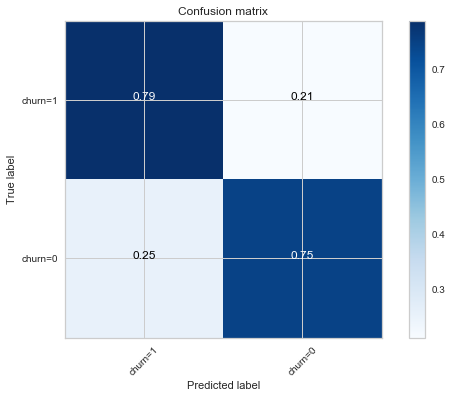

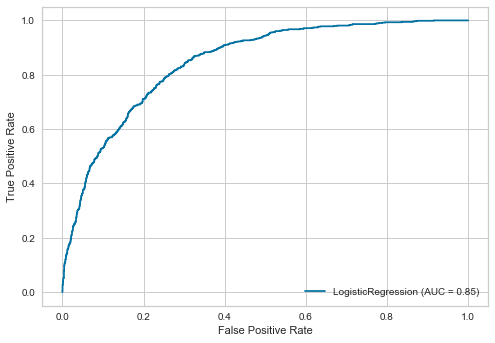

In [38]:
jss, cnf_matrix, c_report, percent_accuracy, auroc = compute_all_evaluation_metrics(clf_smote, 
                                                                                    X_ss_test, 
                                                                                    y_ss_test, 
                                                                                    plot_cm = True, 
                                                                                    print_summary = True, 
                                                                                    )

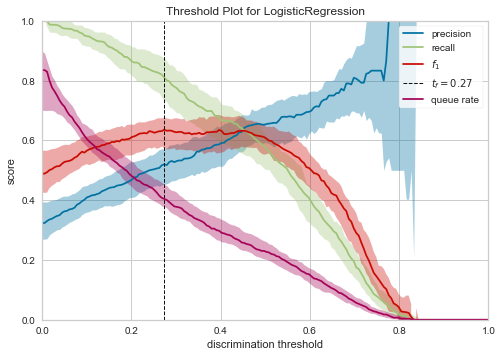

In [39]:
visualizer = DiscriminationThreshold(clf_smote)
visualizer.fit(X_ss_test, y_ss_test)
visualizer.show()

In [50]:
# Check calculated threshold
#X_ss_test, y_ss_test
probability = clf_smote.predict_proba(X_ss_test)[:,0]
new_pred = (probability <0.27).astype(int)


In [53]:
print('percent_accuracy', percent_accurate(y_ss_test,new_pred) )
print( 'clasification report:')
print( classification_report(y_ss_test, new_pred  ) ) #new_pred) )
print ('auroc', roc_auc_score(y_ss_test,  clf_smote.predict_proba(X_ss_test)[:,1]  ) )
print()

percent_accuracy 0.8023462495556346
clasification report:
              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87      2076
         1.0       0.65      0.54      0.59       737

    accuracy                           0.80      2813
   macro avg       0.75      0.72      0.73      2813
weighted avg       0.79      0.80      0.80      2813

auroc 0.8472237472647274



<a id='dt'> </a>
### Decision Trees 

[Go to TOC](#tc)

In [42]:
# get training data - un normalized
decisionTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
decisionTree.fit(X_smt_resampled_un, y_smt_resampled_un)

predTree = decisionTree.predict(X_un_test)
print("DecisionTrees's Accuracy: ",accuracy_score(y_un_test , predTree))
print("AUROC:", roc_auc_score(y_un_test, decisionTree.predict_proba(X_un_test)[:,1]) )

DecisionTrees's Accuracy:  0.7124802527646129
AUROC: 0.7769288133295122


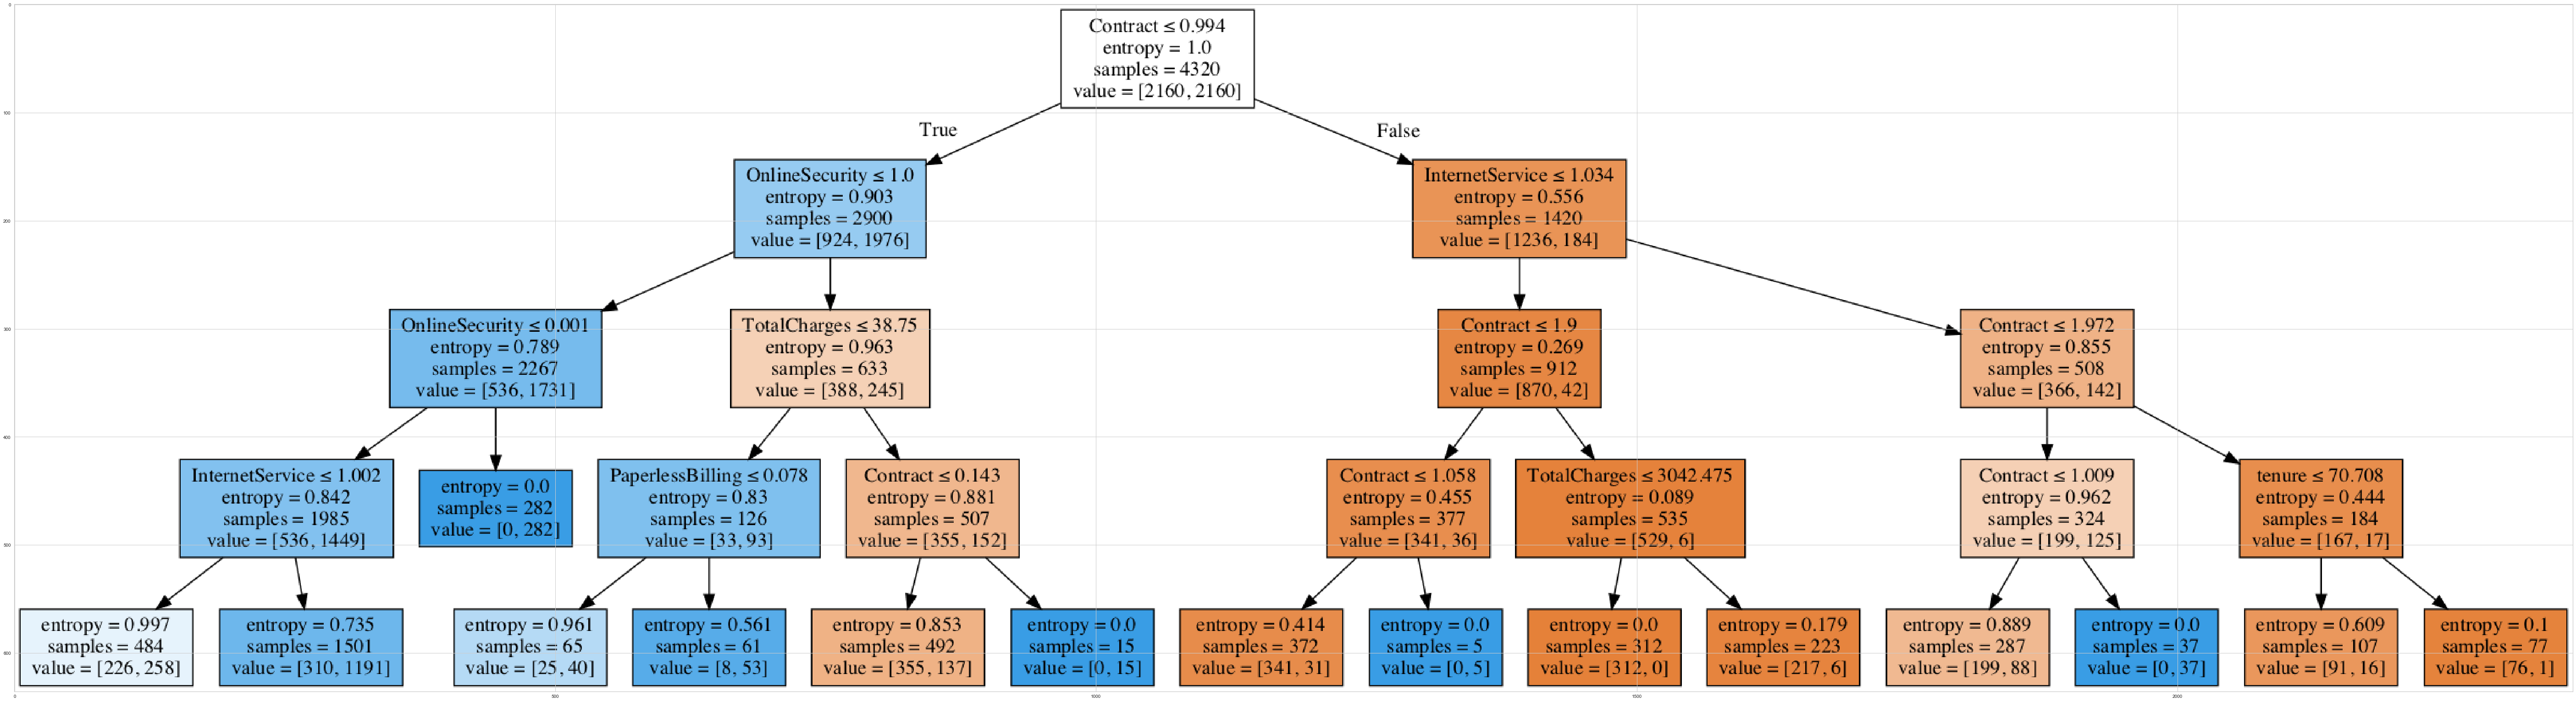

In [43]:
dot_data = StringIO()
filename = "decisiontree.png"
features = churn_num_df.T.index.to_numpy()
features = features[(features != 'Churn') & (features != 'customerID')]
out=tree.export_graphviz(decisionTree,feature_names=features, out_file=dot_data, filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

<a id='rf'> </a>
### Random Forest 

[Go to TOC](#tc)

In [44]:
# train
rfc = RandomForestClassifier(max_depth = 4)
rfc.fit(X_smt_resampled_un, y_smt_resampled_un)
importance_scores = rfc.feature_importances_
feature_importances = [(feature, score) for feature, score in zip(features, importance_scores)]
sorted_features = sorted(feature_importances, key=lambda x: -x[1])

In [45]:
yhat = rfc.predict(X_un_test)
print( 'percent accuracy with RFC:', percent_accurate(y_un_test,yhat) )
print("AUROC:", roc_auc_score(y_un_test, rfc.predict_proba(X_un_test)[:,1]) )
print(sorted_features)

percent accuracy with RFC: 0.7519747235387045
AUROC: 0.8214740241531155
[('Contract', 0.2043848037248208), ('OnlineSecurity', 0.1831734129654456), ('TechSupport', 0.1509466692784483), ('tenure', 0.07997367635315981), ('InternetService', 0.06655535122629147), ('OnlineBackup', 0.05370089319871318), ('DeviceProtection', 0.05146803466428206), ('PaymentMethod', 0.04926192447698121), ('PaperlessBilling', 0.04408554755381076), ('TotalCharges', 0.038967368289485715), ('Partner', 0.02710354972919932), ('MonthlyCharges', 0.015828670934056446), ('Dependents', 0.009283037183168294), ('SeniorCitizen', 0.007514388258881645), ('StreamingMovies', 0.006415384417462148), ('StreamingTV', 0.003687953155393398), ('MultipleLines', 0.0033429096798022664), ('gender', 0.003271966509999098), ('PhoneService', 0.0010344584005984967)]


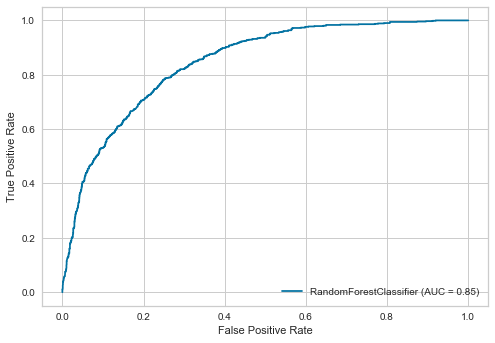

In [46]:
svc_disp = plot_roc_curve(rfc, X_test, y_test)
plt.show()

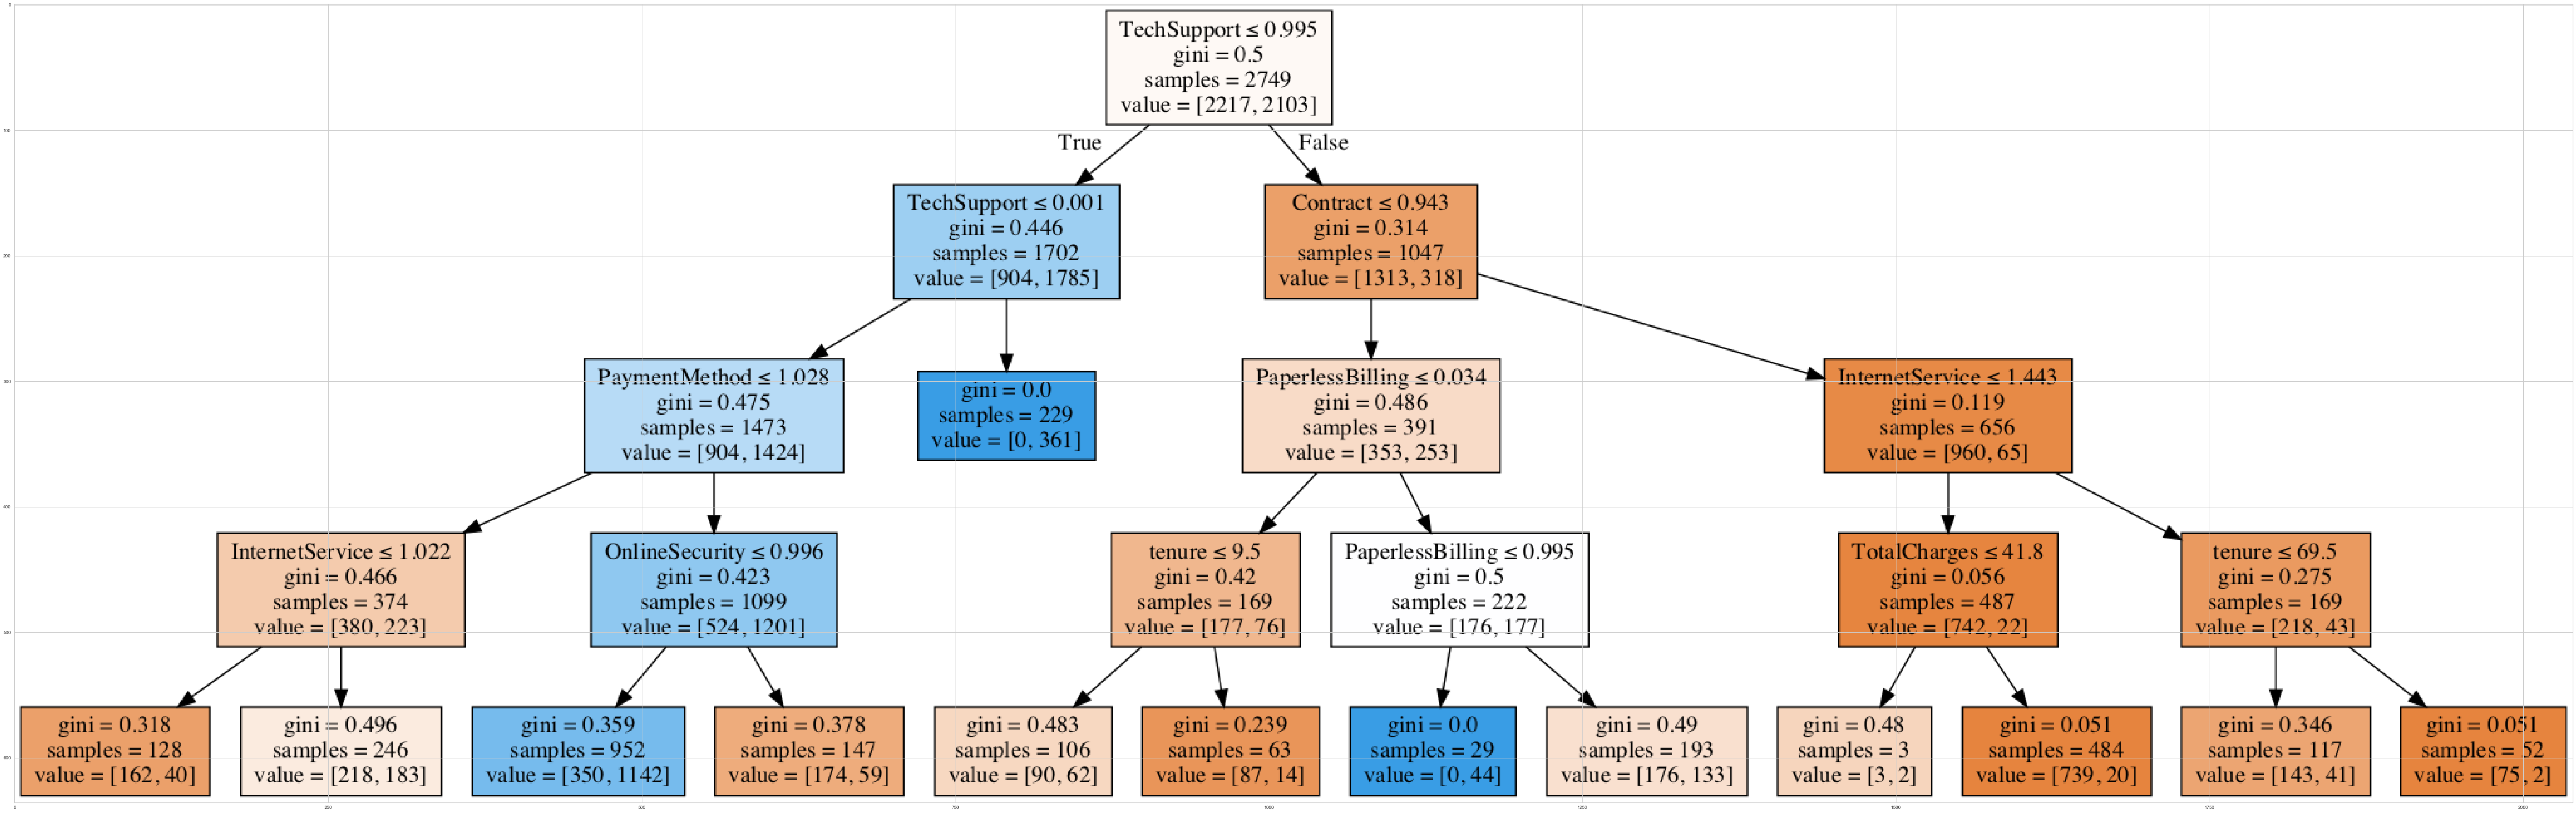

In [47]:
estimator5 = rfc.estimators_[5]
dot_data = StringIO()
filename = "randomforest.png"
out=tree.export_graphviz(estimator5,feature_names=features, out_file=dot_data, filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

<a id='knn'> </a>
### K Nearest Neighbors

[Go to TOC](#tc)

In [48]:
k = 4
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_smote_resampled, y_smote_resampled)
yhat = neigh.predict(X_ss_test)
print("Train set Accuracy: ",accuracy_score(y_ss_train, neigh.predict(X_ss_train)))
print("Test set Accuracy: ", accuracy_score(y_ss_test, yhat))
print("AUROC:", roc_auc_score(y_ss_test, neigh.predict_proba(X_ss_test)[:,1]) )

Train set Accuracy:  0.8620526191040531
Test set Accuracy:  0.7216494845360825
AUROC: 0.7457268309006726


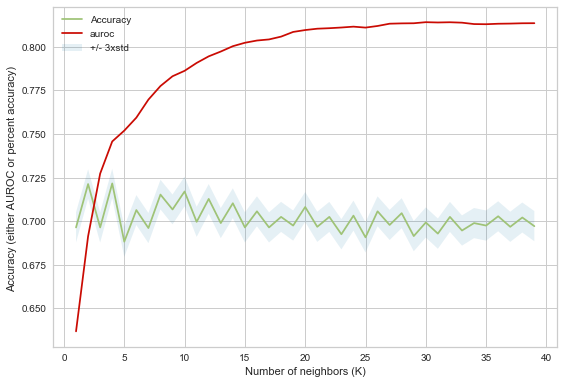

The best AUROC was with 0.8141606078906571 with k= 30


In [49]:
Ks = 40
auroc = np.zeros((Ks-1))
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_smote_resampled, y_smote_resampled)
    yhat=neigh.predict(X_ss_test)
    mean_acc[n-1] = accuracy_score(y_ss_test, yhat)
    std_acc[n-1]=np.std(yhat==y_ss_test)/np.sqrt(yhat.shape[0])
    auroc[n-1]= roc_auc_score(y_ss_test, neigh.predict_proba(X_ss_test)[:,1])
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.plot(range(1,Ks),auroc,'r')
plt.legend(('Accuracy ', 'auroc','+/- 3xstd'))
plt.ylabel('Accuracy (either AUROC or percent accuracy) ')
plt.xlabel('Number of neighbors (K)')
plt.tight_layout()
plt.show()
    
print( "The best AUROC was with", auroc.max(), "with k=", auroc.argmax()+1) 

## Summary and Future Work 

In this notebook, I have investigate the customer Churn or attrition for Telco customers.  I explored multiple machine learning models (LR, Decision trees, random forest and KNN) and found that the best performance was with LR with an AUROC score of .85 and 80% Accuracy (on data set with 75-25 ratio of two classes).  I plan to explore other ML methods to in hopes of increasing accuracy, and do more analysis on feature importance for customer Churn.